In [60]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

df_train = pd.read_csv('../input/train.csv')
train = df_train['review'].to_numpy()
df_y_train = pd.read_csv('../input/y_train.csv')
y_train = df_y_train['rate'].to_numpy()
df_val = pd.read_csv('../input/val.csv')
val = df_val['review'].to_numpy()
df_y_val = pd.read_csv('../input/y_val.csv')
y_val = df_y_val['rate'].to_numpy()

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.test.utils import datapath
from gensim import utils
from pathlib import Path
import gensim
model = gensim.models.Word2Vec.load('../embedding/word2vec.model')
ave_vec = np.zeros((train.shape[0],50),dtype='float')
word_vectors = model.wv
len(word_vectors.vocab)
for k, seq in enumerate(train):
    tokens = gensim.utils.simple_preprocess(seq)
    for i in tokens:
        if i in word_vectors.vocab: 
            ave_vec[k] += model.wv[i]
    ave_vec[k] /= len(tokens)
print(ave_vec.shape)

(22159, 50)


In [61]:
word_vectors = model.wv
len(word_vectors.vocab)
ave_vec_val = np.zeros((val.shape[0],50),dtype='float')
for k, seq in enumerate(val):
    tokens = gensim.utils.simple_preprocess(seq)
    for i in tokens:
        if i in word_vectors.vocab: 
            ave_vec_val[k] += model.wv[i]
    ave_vec_val[k] /= np.array(len(tokens))
print(ave_vec_val.shape)

(5540, 50)


Counter({5.0: 15214, 4.0: 5466, 3.0: 959, 1.0: 263, 2.0: 257})
Counter({5.0: 3804, 4.0: 1367, 3.0: 240, 1.0: 65, 2.0: 64})
Counter({5.0: 15214, 4.0: 10000, 3.0: 2000, 2.0: 1000, 1.0: 1000})


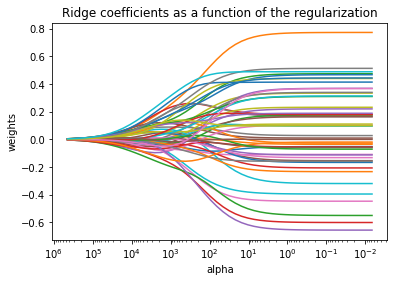

In [97]:
# ridge regression (L2 regularizer)
# 
print(Counter(y_train))
print(Counter(y_val))
stra = {5.0:15214,
        4.0:10000, 
        3.0:2000,
        2.0:1000,
        1.0:1000}
sm = SMOTE(random_state=42, sampling_strategy=stra)
X_res, y_res = sm.fit_resample(ave_vec, y_train)
print(Counter(y_res))
from sklearn import linear_model
n_alphas = 50
alphas = np.exp(np.linspace(-5,13,n_alphas))
coefs = []
train_score = []
val_score = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X_res, y_res)
    train_pre = ridge.predict(ave_vec).astype('int')
    train_pre[train_pre > 5] = np.int(5)
    train_pre[train_pre < 0] = np.int(1)
    val_pre = ridge.predict(ave_vec_val).astype('int')
    val_pre[val_pre > 5] = np.int(5)
    val_pre[val_pre < 1] = np.int(1)
    train_score.append(f1_score(y_train, train_pre, average='macro'))
    val_score.append(f1_score(y_val, val_pre, average='macro'))
    coefs.append(ridge.coef_)
    
cc = np.array(coefs)

ax = plt.gca()
# randomly choose 50 coefficients in the 9676 variables 
# to plot figure of coefs vs regularizer. 
ax.plot(alphas, cc)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

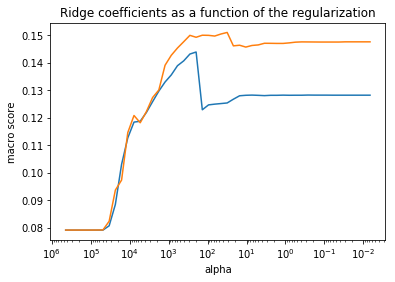

the best macro score on validation set: 0.15098002820153628
confusion matrix is: 
 [[   0    1   49   15    0]
 [   0    1   54    9    0]
 [   0    6  157   74    3]
 [   0    4  424  878   61]
 [   0    6  497 2927  374]]
accuracy of each class:
 [0.0, 0.0156, 0.6542, 0.6423, 0.0983]
the number of wi equal to 0 = 0


In [98]:
train_score = np.array(train_score)
val_score = np.array(val_score)
ax1 = plt.gca()
# randomly choose 50 coefficients in the 9676 variables 
# to plot figure of coefs vs regularizer. 
ax1.plot(alphas, train_score)
ax1.plot(alphas, val_score)
ax1.set_xscale('log')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('macro score')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

alphas_best = alphas[np.argmax(val_score)]
print('the best macro score on validation set:',np.max(val_score))
ridge = linear_model.Ridge(alpha=alphas_best, fit_intercept=True).fit(X_res, y_res)
val_pre = ridge.predict(ave_vec_val).astype('int')
val_pre[val_pre > 5] = np.int(5)
val_pre[val_pre < 1] = np.int(1)
mat = confusion_matrix(y_val, val_pre)
print('confusion matrix is: \n',mat)
print('accuracy of each class:\n',[round(mat[0,0]/mat[0,:].sum(),4), round(mat[1,1]/mat[1,:].sum(),4),
                                  round(mat[2,2]/mat[2,:].sum(),4),round(mat[3,3]/mat[3,:].sum(),4),
                                  round(mat[4,4]/mat[4,:].sum(),4)])
print('the number of wi equal to 0 =',len(np.where(np.abs(ridge.coef_.flatten())==0)[0]))


In [99]:
joblib.dump(ridge,'../input/model_w2v/w2v_ridge.pkl')

['../input/model_w2v/w2v_ridge.pkl']

In [80]:
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
clf = DecisionTreeClassifier(random_state=0,criterion='entropy',
                            splitter='best' )

depth = np.linspace(3,183,61).astype('int')
train_score1 = []
val_score1 = []
for i in depth:
    m = DecisionTreeClassifier(random_state=0,
                               criterion='entropy',
                               splitter='best',
                               max_depth=i,
                               min_samples_leaf=5,
                               min_samples_split=10, 
                               class_weight='balanced'
                              )
    m.fit(X_res, y_res)
    s = f1_score(y_val, m.predict(ave_vec_val), average='macro')
    train_score1.append(f1_score(y_train, m.predict(ave_vec), average='macro'))
    val_score1.append(f1_score(y_val, m.predict(ave_vec_val), average='macro'))
    #print ('Val macro-weighted score is', s)

train_score1 = np.array(train_score1)
val_score1 = np.array(val_score1)

min_leaf = np.linspace(1,101,51).astype('int')
train_score2 = []
val_score2 = []
for i in min_leaf:
    m = DecisionTreeClassifier(random_state=0,
                               criterion='entropy',
                               splitter='best',
                               max_depth=depth[np.argmax(val_score1)],
                               min_samples_leaf=i,
                               min_samples_split=10, 
                               class_weight='balanced'
                              )
    m.fit(X_res, y_res)
    s = f1_score(y_val, m.predict(ave_vec_val), average='macro')
    train_score2.append(f1_score(y_train, m.predict(ave_vec), average='macro'))
    val_score2.append(f1_score(y_val, m.predict(ave_vec_val), average='macro'))

min_samples_spl = np.linspace(5,50,17).astype('int')
train_score3 = []
val_score3 = []
for i in min_samples_spl:
    m = DecisionTreeClassifier(random_state=0,
                               criterion='entropy',
                               splitter='best',
                               max_depth=depth[np.argmax(val_score1)],
                               min_samples_leaf=min_leaf[np.argmax(val_score2)],
                               min_samples_split=i, 
                               class_weight='balanced'
                              )
    m.fit(X_res, y_res)
    s = f1_score(y_val, m.predict(ave_vec_val), average='macro')
    train_score3.append(f1_score(y_train, m.predict(ave_vec), average='macro'))
    val_score3.append(f1_score(y_val, m.predict(ave_vec_val), average='macro'))

m_opt = DecisionTreeClassifier(random_state=0,
                               criterion='entropy',
                               splitter='best',
                               max_depth=depth[np.argmax(val_score1)],
                               min_samples_leaf=min_leaf[np.argmax(val_score2)],
                               min_samples_split=min_samples_spl[np.argmax(val_score3)], 
                               class_weight='balanced'
                              )
m_opt.fit(X_res, y_res)
mat = confusion_matrix(y_val, m_opt.predict(ave_vec_val))
print('optimal score',f1_score(y_val, m_opt.predict(ave_vec_val), average='macro'))
print('confusion matrix is: \n',mat)
print('accuracy of each class:\n',[round(mat[0,0]/mat[0,:].sum(),4), round(mat[1,1]/mat[1,:].sum(),4),
                                  round(mat[2,2]/mat[2,:].sum(),4),round(mat[3,3]/mat[3,:].sum(),4),
                                  round(mat[4,4]/mat[4,:].sum(),4)])



optimal score 0.23430500637813695
confusion matrix is: 
 [[   4    3    8   21   29]
 [   7    4   21   13   19]
 [  11   14   39   94   82]
 [  48   48  133  477  661]
 [  73   66  237 1118 2310]]
accuracy of each class:
 [0.0615, 0.0625, 0.1625, 0.3489, 0.6073]


In [81]:
mat = confusion_matrix(y_val, m_opt.predict(ave_vec_val))
print('optimal score',f1_score(y_val, m_opt.predict(ave_vec_val), average='macro'))
print('confusion matrix is: \n',mat)
print('f1 of each class:\n',f1_score(y_val, m_opt.predict(ave_vec_val), average=None))


optimal score 0.23430500637813695
confusion matrix is: 
 [[   4    3    8   21   29]
 [   7    4   21   13   19]
 [  11   14   39   94   82]
 [  48   48  133  477  661]
 [  73   66  237 1118 2310]]
f1 of each class:
 [0.03846154 0.04020101 0.11504425 0.30873786 0.66908038]


24
0.23279484750733576
1
0.23430500637813695
10
0.23430500637813695


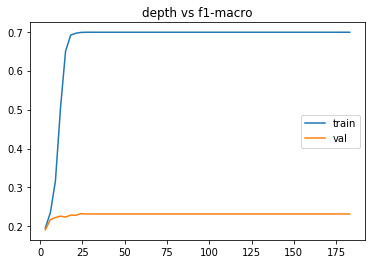

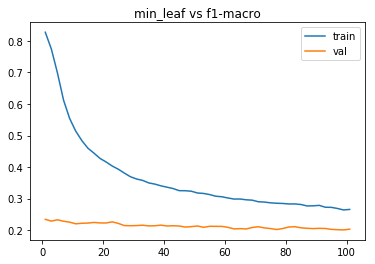

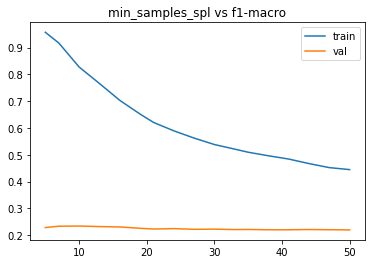

In [82]:
plt.figure()
plt.plot(depth,train_score1,label='train')
plt.plot(depth,val_score1,label='val')
plt.legend()
plt.title('depth vs f1-macro')
print(depth[np.argmax(val_score1)])
print(np.max(val_score1))
pass
plt.figure()
plt.plot(min_leaf,train_score2,label='train')
plt.plot(min_leaf,val_score2,label='val')
plt.legend()
plt.title('min_leaf vs f1-macro')
print(min_leaf[np.argmax(val_score2)])
print(np.max(val_score2))
pass
plt.figure()
plt.plot(min_samples_spl,train_score3,label='train')
plt.plot(min_samples_spl,val_score3,label='val')
plt.legend()
plt.title('min_samples_spl vs f1-macro')
print(min_samples_spl[np.argmax(val_score3)])
print(np.max(val_score3))
pass

In [83]:
joblib.dump(m_opt,'../input/model_w2v/decision_tree_w2v.pkl')

['../input/model_w2v/decision_tree_w2v.pkl']

Counter({5.0: 15214, 4.0: 5466, 3.0: 959, 1.0: 263, 2.0: 257})
Counter({5.0: 3804, 4.0: 1367, 3.0: 240, 1.0: 65, 2.0: 64})
Counter({5.0: 15214, 4.0: 10000, 3.0: 2000, 2.0: 1000, 1.0: 1000})


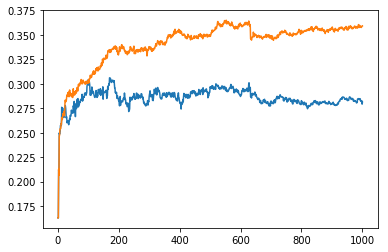

In [71]:
# Adaboost with tree method
#import warnings
#warnings.filterwarnings("ignore")
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
print(Counter(y_train))
print(Counter(y_val))
stra = {5.0:15214,
        4.0:10000, 
        3.0:2000,
        2.0:1000,
        1.0:1000}
sm = SMOTE(random_state=42, sampling_strategy=stra)
X_res, y_res = sm.fit_resample(ave_vec, y_train)
print(Counter(y_res))
clf = AdaBoostClassifier(n_estimators=1000, random_state=1)
clf.fit(X_res, y_res)
real_val_macro = [0]
train_macro = []
for real_test_predict in clf.staged_predict(ave_vec_val):
    if f1_score(y_val, real_test_predict, average='macro')> np.max(real_val_macro) :
        pred_opt = f1_score(y_val, real_test_predict, average='macro')
    real_val_macro.append(
        f1_score(y_val, real_test_predict, average='macro'))
for real_train_predict in clf.staged_predict(ave_vec):
    train_macro.append(f1_score(y_train, real_train_predict, average='macro'))
    

n_trees_real = len(clf)
plt.figure()
plt.plot(range(1, n_trees_real + 1),
         real_val_macro[1:], 
         label='val')
plt.plot(range(1, n_trees_real + 1),
         train_macro,
         label='train')

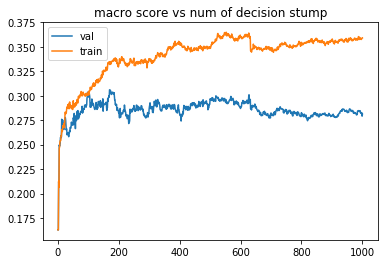

In [72]:
plt.figure()
plt.plot(range(1, n_trees_real + 1),
         real_val_macro[1:], 
         label='val')
plt.plot(range(1, n_trees_real + 1),
         train_macro,
         label='train')
plt.legend()
plt.title('macro score vs num of decision stump')
adaboost_opt = AdaBoostClassifier(n_estimators=np.argmax(real_val_macro[1:])+1, 
                                  random_state=1)

In [73]:
pred_opt

0.30599352334303764

In [76]:
adaboost_opt.fit(X_res, y_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=170, random_state=1)

In [84]:
f1_score(y_val, adaboost_opt.predict(ave_vec_val), average='macro')

0.30599352334303764

In [89]:
joblib.dump(adaboost_opt,'../input/model_w2v/w2v_adaboost.pkl')

['../input/model_w2v/w2v_adaboost.pkl']

In [86]:
np.argmax(real_val_macro[1:])+1

170

In [88]:
w2v_adaboost = adaboost_opt
print('Word2Vec feature: Adaboost, best F1-macro score on validation set:',f1_score(y_val, w2v_adaboost.predict(ave_vec_val), average='macro'))
mat = confusion_matrix(y_val, w2v_adaboost.predict(ave_vec_val))
print('confusion matrix on validation set is: \n',mat)
print('F1 score of each class:\n',f1_score(y_val, w2v_adaboost.predict(ave_vec_val), average=None))
print('accuracy on validation set:', w2v_adaboost.score(ave_vec_val,y_val),'\n\n')

Word2Vec feature: Adaboost, best F1-macro score on validation set: 0.30599352334303764
confusion matrix on validation set is: 
 [[  18    7    4   15   21]
 [  15    6    2   19   22]
 [  18   14   21  111   76]
 [  28   32   28  429  850]
 [  46   30   26  580 3122]]
F1 score of each class:
 [0.18947368 0.07843137 0.13084112 0.34034113 0.7908803 ]
accuracy on validation set: 0.6490974729241877 


